In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


In [83]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    batch_size : int
        Batch size for SGD

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, M=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.batch_size = M
        self.shuffle = shuffle
        if random_state : np.random.seed(random_state)

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []

            for j in range(X.shape[0] // self.batch_size):
                cost.append(self._update_weights(X[j * self.batch_size : j * self.batch_size + self.batch_size], 
                                                 y[j * self.batch_size : j * self.batch_size + self.batch_size]))
            
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)

        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)

        # Cost function
        error = (yi - output)
        cost = 0.5 * np.sum(error ** 2)

        # Update rule
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()

        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])                
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

In [84]:
def evaluate_function(batch_size):
    adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1, M=batch_size)
    adas.fit(X_train_std, y_train)
    y_pred = adas.predict(X_test_std)
    
    print(f'-------------adaSGD with batch_size={batch_size}-----------------')
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))
    return adas

-------------adaSGD with batch_size=1-----------------
Misclassified samples: 3
Accuracy: 0.85

-------------adaSGD with batch_size=10-----------------
Misclassified samples: 3
Accuracy: 0.85

-------------adaSGD with batch_size=50-----------------
Misclassified samples: 3
Accuracy: 0.85



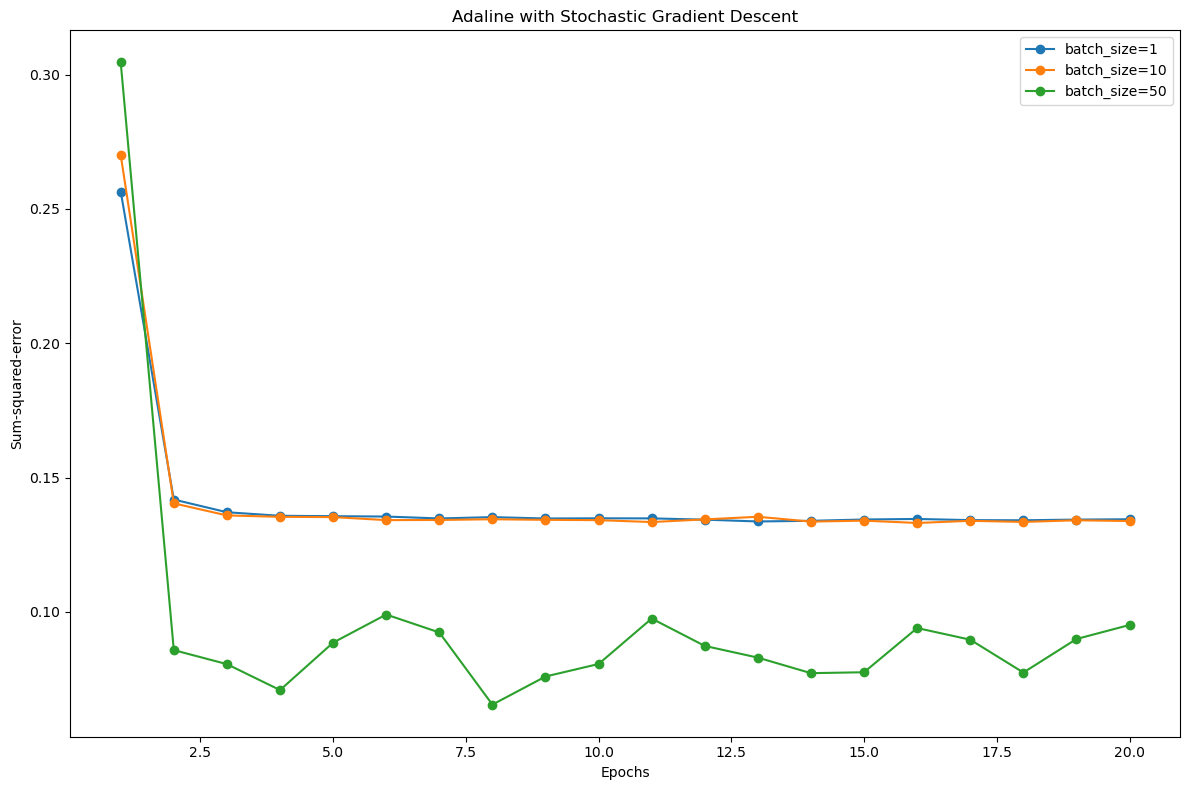

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

adaSGD1 = evaluate_function(batch_size=1)
plt.plot(range(1, len(adaSGD1.cost_) + 1), adaSGD1.cost_, marker='o', label=f'batch_size={adaSGD1.batch_size}')
adaSGD2 = evaluate_function(batch_size=10)
plt.plot(range(1, len(adaSGD2.cost_) + 1), adaSGD2.cost_, marker='o', label=f'batch_size={adaSGD2.batch_size}')
adaSGD3 = evaluate_function(batch_size=50)
plt.plot(range(1, len(adaSGD3.cost_) + 1), adaSGD3.cost_, marker='o', label=f'batch_size={adaSGD3.batch_size}')

plt.title('Adaline with Stochastic Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./Lab04-1_111062678.png', dpi=300)
plt.show()